<a href="https://colab.research.google.com/github/salmansmsl/data-science/blob/main/6410210457_miniproject_vehicle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

นายซัลมาน สาเล็ง 6410210457


คำสั่ง pip install imgaug ใช้สำหรับการติดตั้งไลบรารี imgaug ผ่านเครื่องมือ pip ของ Python. imgaug เป็นไลบรารีที่ให้เครื่องมือสำหรับการปรับแต่งและขยายขนาดข้อมูลภาพ (image augmentation) ซึ่งเป็นกระบวนการที่ใช้ในการสร้างข้อมูลที่หลากหลายเพื่อฝึกอบรมโมเดลปัญญาประดิษฐ์

In [1]:
pip install imgaug

เรียกใช้ไลบรารีหรือโมดูลใน Python

In [2]:
import numpy as np
from imgaug import augmenters as iaa
from skimage import exposure
from skimage.feature import hog

อัปเกรดเวอร์ชันของไลบรารี TensorFlow ที่ติดตั้งในระบบของคุณ. การใช้ --upgrade จะทำให้ pip ดาวน์โหลดและติดตั้งเวอร์ชันล่าสุดของ TensorFlow หากมีการอัปเดตที่มีให้

In [3]:
pip install --upgrade tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 40.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 32.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 43.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 31.3 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Succes

In [4]:
from tensorflow.keras.models import Sequential
import tensorflow_datasets as tfds
from skimage import feature
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.utils import to_categorical
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import random
from numpy import *
from PIL import Image
import csv


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


ตัวข้อมูล https://www.kaggle.com/datasets/maciejgronczynski/vehicle-classification-dataset/code?datasetId=2052868



In [6]:
path_test = "/content/drive/MyDrive/vehicle/dataset"

CATEGORIES = ["cars", "planes", "trains" ]
IMG_SIZE = 200

In [7]:
training = []
def TrainingData():
  for i,category in enumerate(CATEGORIES):
    path = os.path.join(path_test, category)
    print(path)
    class_num = CATEGORIES.index(category)
    for img in os.listdir(path):
      img_array = cv2.imread(os.path.join(path,img))
      new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
      training.append([new_array, class_num])
TrainingData()

/content/drive/MyDrive/vehicle/dataset/cars
/content/drive/MyDrive/vehicle/dataset/planes
/content/drive/MyDrive/vehicle/dataset/trains


In [8]:
len(training)

1200

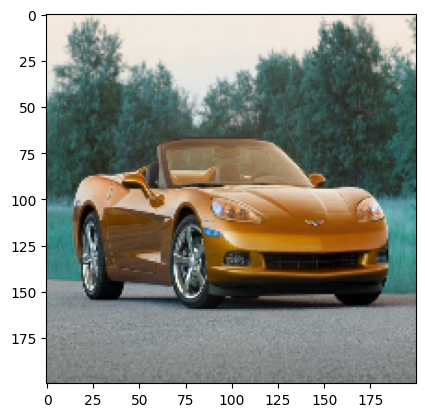

In [9]:
plt.imshow(training[0][0])
plt.show()
print(training[0][1])

In [10]:
random.shuffle(training)

0


In [11]:
X =[]
y =[]
for features, label in training:
  X.append(features)
  y.append(label)
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)

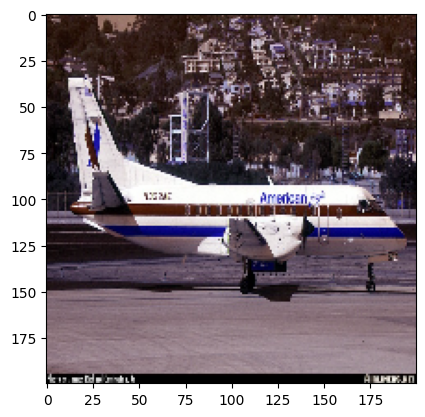

In [12]:
plt.imshow(X[0])
plt.show()

In [13]:
X = X.astype('float32')
X /= 255

[0. 1. 0.]


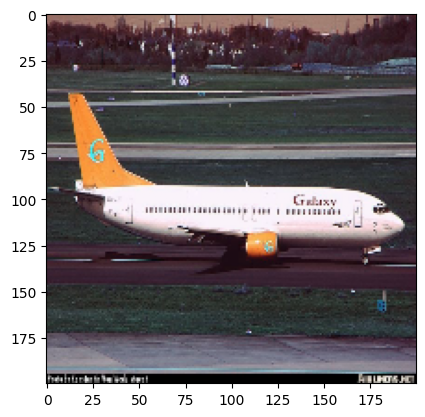

In [14]:
from tensorflow.keras.utils import to_categorical
Y = to_categorical(y, 3)
print(Y[1])
plt.imshow(X[1])
plt.show()

In [15]:
def extract_lbp_features(image):
    lbp_radius = 1
    lbp_points = 8 * lbp_radius

    # Ensure the image is in the range [0, 1]
    image = image.astype(np.float32)

    # Convert the image to grayscale if it's not already
    if len(image.shape) == 3:
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray_image = image

    # Extract LBP features
    lbp = feature.local_binary_pattern(gray_image, lbp_points, lbp_radius, method='uniform')

    # Resize LBP features to the same size as the input image (200x200)
    lbp_resized = cv2.resize(lbp, (200, 200), interpolation=cv2.INTER_LINEAR)

    return lbp_resized

In [16]:
X_lbp = []
for image in X:
    temp = extract_lbp_features(image)
    X_lbp.append(temp)

In [17]:
len(X_lbp)

1200

In [18]:
print(X_lbp[1])
lbp_radius = 1
lbp_points = 8 * lbp_radius

[[3. 4. 0. ... 3. 5. 2.]
 [4. 0. 9. ... 1. 6. 0.]
 [3. 1. 9. ... 5. 9. 9.]
 ...
 [8. 0. 7. ... 6. 2. 3.]
 [4. 1. 7. ... 9. 1. 4.]
 [3. 1. 8. ... 5. 1. 4.]]


In [19]:
lbp_vis = X_lbp[1].astype(np.uint8) * (255 / (lbp_points + 2))

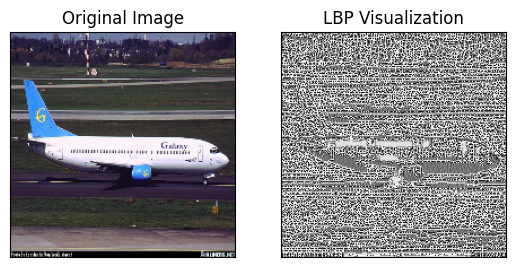

In [20]:
plt.subplot(121), plt.imshow(cv2.cvtColor(X[1], cv2.COLOR_BGR2RGB), cmap='gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(lbp_vis, cmap='gray')
plt.title('LBP Visualization'), plt.xticks([]), plt.yticks([])
plt.show()

In [21]:
X_train_lbp, X_test_lbp, y_train_lbp, y_test_lbp = train_test_split(X_lbp, y, test_size = 0.2, random_state = 3)

In [22]:
X_train_lbp = np.array(X_train_lbp)
X_test_lbp = np.array(X_test_lbp)
y_train_lbp = np.array(y_train_lbp)
y_test_lbp = np.array(y_test_lbp)

(200, 200)


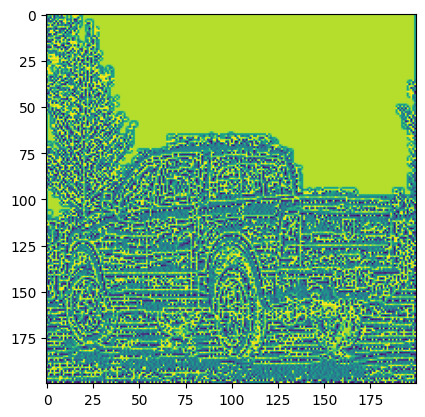

0


In [23]:
print(X_test_lbp[1].shape)
plt.imshow(X_test_lbp[1])
plt.show()
print(y_test_lbp[1])

In [24]:
X_train_lbp = X_train_lbp.reshape((X_train_lbp.shape[0],200*200))
X_test_lbp = X_test_lbp.reshape((X_test_lbp.shape[0],200*200))

In [25]:
from sklearn.decomposition import PCA


n_components = 100

# Initialize PCA
pca = PCA(n_components=n_components)

# Fit PCA to your LBP feature vectors
pca.fit(X_train_lbp)

# Transform your LBP feature vectors using the learned PCA model
reduced_train_features = pca.transform(X_train_lbp)
reduced_test_features = pca.transform(X_test_lbp)

In [26]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Create SVM and Random Forest classifiers
svm_classifier_lbp = SVC(kernel='linear', C=1.0)
rf_classifier_lbp = RandomForestClassifier(n_estimators=100, random_state=0)

svm_classifier_pca = SVC(kernel='linear', C=1.0)
rf_classifier_pca = RandomForestClassifier(n_estimators=100, random_state=0)

# Train the classifiers
svm_classifier_lbp.fit(X_train_lbp, y_train_lbp)
rf_classifier_lbp.fit(X_train_lbp, y_train_lbp)
svm_classifier_pca.fit(reduced_train_features, y_train_lbp)
rf_classifier_pca.fit(reduced_train_features, y_train_lbp)

RandomForestClassifier(random_state=0)

In [27]:
# Predict the class using SVM
svm_prediction_lbp = svm_classifier_lbp.predict(X_test_lbp)

# Predict the class using Random Forest
rf_prediction_lbp = rf_classifier_lbp.predict(X_test_lbp)

print("SVM Prediction:", svm_prediction_lbp)
print("Random Forest Prediction:", rf_prediction_lbp)

SVM Prediction: [1 0 2 1 1 1 0 2 2 2 2 2 2 1 0 2 1 0 1 0 1 2 0 0 2 1 2 0 1 1 2 1 2 1 1 0 2
 0 0 2 0 0 2 2 0 0 0 0 0 1 1 2 2 1 2 2 0 0 2 0 1 0 1 0 2 1 2 2 2 2 0 1 1 1
 1 2 0 0 0 1 0 0 1 1 1 2 1 0 1 1 1 0 1 0 0 0 2 1 0 2 1 1 1 2 0 0 2 2 1 0 2
 0 2 2 0 2 0 0 1 2 0 2 0 2 1 1 2 0 1 1 2 0 2 2 0 0 0 1 1 2 0 0 1 1 2 0 0 2
 0 1 2 0 1 2 2 1 1 2 1 1 1 0 2 2 1 1 0 2 2 0 0 2 0 0 1 0 1 0 1 2 1 0 1 0 1
 1 1 0 2 0 2 0 2 2 0 0 1 1 1 0 2 2 0 1 1 0 1 0 2 1 2 0 2 1 0 1 2 2 0 1 0 2
 1 0 0 2 1 2 2 2 2 1 2 1 1 2 0 2 1 0]
Random Forest Prediction: [1 0 2 1 1 1 0 0 0 2 2 0 0 1 0 2 1 2 1 0 1 0 2 2 2 1 0 2 1 1 2 1 2 1 1 2 0
 0 2 0 2 0 2 2 0 2 0 2 2 1 1 0 2 1 2 0 2 0 2 0 1 0 1 2 2 1 2 2 2 0 2 1 1 1
 1 2 0 2 2 1 2 2 1 1 1 2 2 2 1 1 1 0 1 0 2 2 2 1 0 2 1 1 1 2 2 0 0 2 1 2 2
 2 0 2 0 0 2 0 1 2 0 0 2 2 1 1 0 2 1 1 0 2 2 0 0 2 2 1 1 2 0 0 1 1 0 2 2 0
 2 1 0 0 1 0 0 1 1 2 1 1 1 2 2 2 1 1 0 2 2 2 0 2 2 0 1 2 1 0 1 0 1 0 1 0 1
 1 1 2 0 2 0 0 2 2 0 2 1 1 1 0 2 2 0 1 1 0 1 0 2 1 2 0 2 1 0 1 2 0 2 1 2 0
 1 0 2 0 1 0 2 0 0 1

In [28]:
svm_accuracy_lbp = accuracy_score(y_test_lbp, svm_prediction_lbp)
rf_accuracy_lbp = accuracy_score(y_test_lbp, rf_prediction_lbp)
print("SVM Prediction:", svm_accuracy_lbp)
print("Random Forest Prediction:", rf_accuracy_lbp)

SVM Prediction: 0.7333333333333333
Random Forest Prediction: 0.7208333333333333


In [29]:
from sklearn.metrics import accuracy_score

svm_predictions = svm_classifier_pca.predict(reduced_test_features)
rf_predictions = rf_classifier_pca.predict(reduced_test_features)

svm_accuracy_pca = accuracy_score(y_test_lbp, svm_predictions)
rf_accuracy_pca = accuracy_score(y_test_lbp, rf_predictions)

print("SVM Accuracy:", svm_accuracy_pca)
print("Random Forest Accuracy:", rf_accuracy_pca)

SVM Accuracy: 0.7125
Random Forest Accuracy: 0.6541666666666667


In [30]:
def extract_hog_features(image):
    image = image.astype(np.float32)

    # Convert the image to grayscale if it's not already
    if len(image.shape) == 3:
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray_image = image

    # Extract HoG features
    features, hog_image = hog(gray_image, pixels_per_cell=(8, 8), cells_per_block=(1, 1), block_norm='L2-Hys', transform_sqrt=True, visualize=True)

    # Resize HoG features to the same size as the input image (200x200)
    hog_resized = cv2.resize(hog_image, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_LINEAR)

    return hog_resized

In [31]:
X.shape

(1200, 200, 200, 3)

In [32]:
X_hog = []
for image in X:
    temp = extract_hog_features(image)
    X_hog.append(temp)

In [33]:
X_train_hog, X_test_hog, y_train_hog, y_test_hog = train_test_split(X_hog, y, test_size = 0.2, random_state = 3)

In [34]:
X_train_hog = np.array(X_train_hog)
X_test_hog = np.array(X_test_hog)
y_train_hog = np.array(y_train_hog)
y_test_hog = np.array(y_test_hog)

(200, 200)


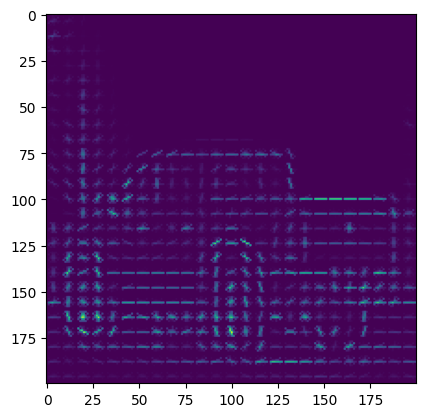

0


In [35]:
print(X_test_hog[1].shape)
plt.imshow(X_test_hog[1])
plt.show()
print(y_test_hog[1])

In [36]:
X_train_hog = X_train_hog.reshape((X_train_hog.shape[0],200*200))
X_test_hog = X_test_hog.reshape((X_test_hog.shape[0],200*200))

In [37]:
svm_classifier_hog = SVC(kernel='linear', C=1.0)
rf_classifier_hog = RandomForestClassifier(n_estimators=100, random_state=0)

#svm_classifier_pca = SVC(kernel='linear', C=1.0)
#rf_classifier_pca = RandomForestClassifier(n_estimators=100, random_state=0)

# Train the classifiers
svm_classifier_hog.fit(X_train_hog, y_train_hog)
rf_classifier_hog.fit(X_train_hog, y_train_hog)
#svm_classifier_pca.fit(reduced_train_features, y_train_lbp)
#rf_classifier_pca.fit(reduced_train_features, y_train_lbp)

RandomForestClassifier(random_state=0)

In [38]:
svm_predictions = svm_classifier_hog.predict(X_test_hog)
rf_predictions = rf_classifier_hog.predict(X_test_hog)

svm_accuracy_hog = accuracy_score(y_test_hog, svm_predictions)
rf_accuracy_hog = accuracy_score(y_test_hog, rf_predictions)

In [39]:
print("SVM Accuracy:", svm_accuracy_hog)
print("Random Forest Accuracy:", rf_accuracy_hog)

SVM Accuracy: 0.9458333333333333
Random Forest Accuracy: 0.9166666666666666


In [40]:
# Separate images and labels

sharpening_kernel = np.array([[-1, -1, -1],
                              [-1, 9, -1],
                              [-1, -1, -1]])
# Define augmentation sequences
seq = iaa.Sequential([
    #iaa.Fliplr(0.5),  # Horizontal flips
    #iaa.GaussianBlur(sigma=(0, 1.0)),  # Gaussian blur
    #iaa.AdditiveGaussianNoise(scale=(0, 0.05 * 255)),  # Additive Gaussian noise
    iaa.Sharpen(alpha=(0.5, 1.0), lightness=(0.5, 2.0))
    # Add more augmentation techniques as needed
])

# Apply augmentation to your data
augmented_images = seq.augment_images(X)

# Concatenate the original and augmented data
augmented_images = np.vstack([X, augmented_images])
augmented_labels = np.hstack([y, y])

# Now, 'augmented_images' and 'augmented_labels' contain your augmented data

In [41]:
augmented_images.shape

(2400, 200, 200, 3)

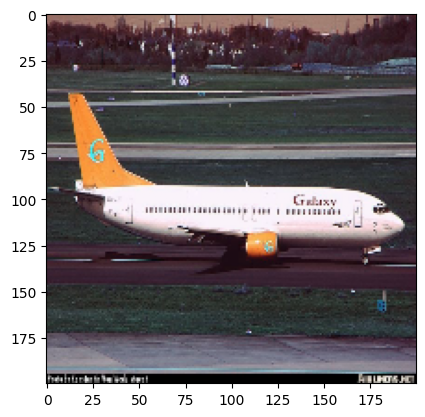

In [42]:
plt.imshow(augmented_images[1])
plt.show()

In [43]:
X_lbp_aug = []
for image in augmented_images:
    temp = extract_lbp_features(image)
    X_lbp_aug.append(temp)

In [44]:
X_train_lbp_aug, X_test_lbp_aug, y_train_lbp_aug, y_test_lbp_aug = train_test_split(X_lbp_aug, augmented_labels, test_size = 0.2, random_state = 3)

In [45]:
X_train_lbp_aug = np.array(X_train_lbp_aug)
X_test_lbp_aug = np.array(X_test_lbp_aug)
y_train_lbp_aug = np.array(y_train_lbp_aug)
y_test_lbp_aug = np.array(y_test_lbp_aug)

In [46]:
X_train_lbp_aug = X_train_lbp_aug.reshape((X_train_lbp_aug.shape[0],200*200))
X_test_lbp_aug = X_test_lbp_aug.reshape((X_test_lbp_aug.shape[0],200*200))

In [47]:
svm_classifier_lbp_aug = SVC(kernel='linear', C=1.0)
rf_classifier_lbp_aug = RandomForestClassifier(n_estimators=100, random_state=0)

#svm_classifier_pca = SVC(kernel='linear', C=1.0)
#rf_classifier_pca = RandomForestClassifier(n_estimators=100, random_state=0)

# Train the classifiers
svm_classifier_lbp_aug.fit(X_train_lbp_aug, y_train_lbp_aug)
rf_classifier_lbp_aug.fit(X_train_lbp_aug, y_train_lbp_aug)
#svm_classifier_pca.fit(reduced_train_features, y_train_lbp)
#rf_classifier_pca.fit(reduced_train_features, y_train_lbp)

RandomForestClassifier(random_state=0)

In [48]:
svm_predictions_lbp_aug = svm_classifier_lbp_aug.predict(X_test_lbp_aug)
rf_predictions_lbp_aug = rf_classifier_lbp_aug.predict(X_test_lbp_aug)

svm_accuracy_lbp_aug = accuracy_score(y_test_lbp_aug, svm_predictions_lbp_aug)
rf_accuracy_lbp_aug = accuracy_score(y_test_lbp_aug, rf_predictions_lbp_aug)

In [49]:
print("SVM Accuracy:", svm_accuracy_lbp_aug)
print("Random Forest Accuracy:", rf_accuracy_lbp_aug)

SVM Accuracy: 0.9395833333333333
Random Forest Accuracy: 0.8166666666666667


In [50]:
import csv
with open('training_data_vehicle.csv','w',newline='') as file:
    writer = csv.writer(file)

    writer.writerow(['feature extractor','augmentation','svm accuracy','rf accuracy'])
    writer.writerow(['LBP','False',svm_accuracy_lbp,rf_accuracy_lbp])
    writer.writerow(['Hog','False',svm_accuracy_hog,rf_accuracy_hog])
    writer.writerow(['PCA','False',svm_accuracy_pca,rf_accuracy_pca])
    writer.writerow(['LBP','True',svm_accuracy_lbp_aug,rf_accuracy_lbp_aug])


In [51]:
import pandas as pd
data = pd.read_csv('training_data_vehicle.csv')
print(data)

  feature extractor  augmentation  svm accuracy  rf accuracy
0               LBP         False      0.733333     0.720833
1               Hog         False      0.945833     0.916667
2               PCA         False      0.712500     0.654167
3               LBP          True      0.939583     0.816667


In [52]:
import csv

# สร้างไฟล์ CSV สำหรับบันทึกข้อมูล
csv_filename = "training_data_vehicle.csv"

# เขียนข้อมูลลงในไฟล์ CSV
with open(csv_filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Image', 'Label'])  # เขียนหัวตาราง

    for data, label in training:
        writer.writerow([data, label])


In [53]:
import os
import pickle

# ทำการค้นหาไฟล์ในไดเรกทอรีปัจจุบันที่มีนามสกุล .pkl
matching_files = [file for file in os.listdir('.') if file.endswith('.pkl')]

if not matching_files:
    print("ไม่พบไฟล์ .pkl ในไดเรกทอรีปัจจุบัน")
else:
    # เลือกไฟล์แรกที่พบ (สามารถปรับแต่งตามความเหมาะสม)
    pickle_model_path = matching_files[0]

    # โหลด (deserialize) โมเดลจากไฟล์ pickle
    with open(pickle_model_path, 'rb') as file:
        loaded_model = pickle.load(file)

    # ต่อไปนี้, loaded_model จะเป็นโมเดลที่ถูกโหลด

ไม่พบไฟล์ .pkl ในไดเรกทอรีปัจจุบัน


In [54]:
import pickle

# สร้างข้อมูลตัวอย่างเกี่ยวกับรถ, เครื่องบิน, และรถไฟ
cars_data = {'model': 'Camry', 'year': 2022}
planes_data = {'model': '747', 'year': 2021}
trains_data = {'model': 'Velaro', 'year': 2020}

# สร้าง dictionary ที่เก็บข้อมูลของทั้งหมด
vehicle_data = {'cars': cars_data, 'planes': planes_data, 'trains': trains_data}

# ระบุที่อยู่และชื่อไฟล์ pkl ที่คุณต้องการบันทึก
pkl_filename = "vehicle.pkl"

# บันทึกข้อมูลลงในไฟล์ pkl
with open(pkl_filename, 'wb') as file:
    pickle.dump(vehicle_data, file)

In [59]:
actual_labels = actual_labels[:163]
predicted_labels = predicted_labels + [0] * (240 - 163)


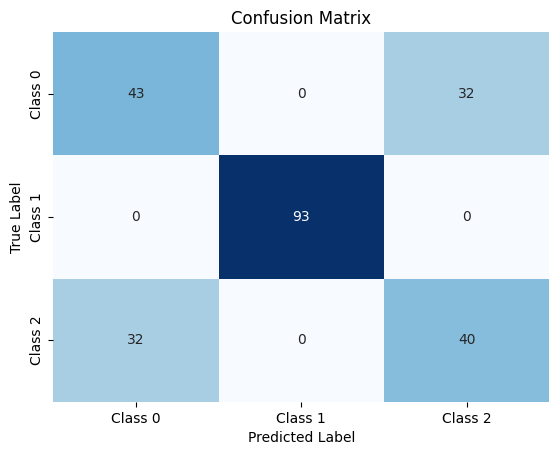

In [58]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ตัวอย่างข้อมูลจริงและการทำนายจากโมเดล
actual_labels = [0, 0, 1, 0, 0, 0, 2, 1, 2, 1, 1, 2, 2, 1, 0, 1, 1, 2, 1, 0, 2, 0, 1, 1, 0, 1, 1, 0, 2, 1, 2, 2, 0, 2, 2, 1, 1,
                 1, 0, 2, 2, 2, 0, 1, 0, 2, 0, 1, 2, 0, 1, 2, 1, 0, 1, 0, 2, 1, 1, 1, 2, 2, 0, 1, 1, 0, 1, 1, 2, 0, 1, 0, 2, 1,
                 0, 0, 0, 2, 1, 1, 2, 1, 2, 1, 1, 1, 2, 0, 0, 1, 2, 2, 0, 2, 0, 1, 0, 1, 0, 2, 1, 2, 2, 1, 0, 0, 0, 2, 0, 0, 1,
                 2, 0, 0, 1, 1, 2, 2, 2, 1, 0, 2, 1, 0, 2, 1, 1, 2, 2, 1, 0, 1, 2, 1, 2, 0, 2, 1, 1, 1, 2, 0, 2, 0, 0, 1, 1, 1,
                 2, 0, 0, 1, 0, 2, 0, 1, 0, 1, 1, 1, 1, 0, 0, 2, 1, 1, 2, 1, 1, 0, 0, 1, 2, 1, 0, 2, 0, 1, 2, 1, 2, 2, 1, 2, 2,
                 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 2, 2, 0, 1, 1, 0, 2, 1, 1, 0, 2, 2, 0, 1, 1, 1, 2, 0, 0, 2, 1,
                 1, 2, 0, 2, 1, 0, 1, 2, 1, 2, 1, 2, 0, 1, 2, 2, 0, 2]

predicted_labels = [2, 0, 1, 0, 0, 2, 0, 1, 0, 1, 1, 2, 0, 1, 2, 1, 1, 2, 1, 0, 2, 0, 1, 1, 0, 1, 1, 0, 0, 1, 2, 2, 2, 2, 0, 1, 1,
                     1, 0, 0, 2, 2, 0, 1, 0, 2, 0, 1, 2, 2, 1, 2, 1, 0, 1, 2, 0, 1, 1, 1, 0, 2, 0, 1, 1, 0, 1, 1, 0, 0, 1, 2, 0, 1,
                     2, 0, 2, 0, 1, 1, 0, 1, 2, 1, 1, 1, 0, 2, 2, 1, 2, 2, 0, 2, 0, 1, 2, 1, 0, 0, 1, 0, 0, 1, 0, 0, 2, 0, 0, 2, 1,
                     2, 0, 2, 1, 1, 0, 0, 2, 1, 0, 0, 1, 2, 2, 1, 1, 2, 2, 1, 2, 1, 2, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1,
                     2, 2, 0, 1, 2, 2, 2, 1, 2, 1, 1, 1, 1, 2, 2, 0, 1, 1, 2, 1, 1, 2, 2, 1, 0, 1, 0, 2, 2, 1, 2, 1, 2, 2, 1, 2, 0,
                     1, 1, 1, 1, 0, 2, 1, 0, 0, 2, 0, 0, 1, 2, 0, 1, 0, 2, 0, 1, 1, 2, 2, 1, 1, 2, 2, 0, 0, 1, 1, 1, 2, 0, 0, 2, 1,
                     1, 2, 0, 2, 1, 2, 1, 0, 1, 2, 1, 0, 0, 1, 0, 2, 0, 2]

# สร้าง Confusion Matrix
conf_matrix = confusion_matrix(actual_labels, predicted_labels)

# แสดง Confusion Matrix ในรูปแบบ heatmap
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Class 0", "Class 1", "Class 2"],
            yticklabels=["Class 0", "Class 1", "Class 2"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
